In [1]:
# Use warpx_env as kernal
import numpy as np
import h5py
import matplotlib.colors as colors
import scipy
import matplotlib.pyplot as plt
import scipy.constants as cons
from matplotlib.colors import LinearSegmentedColormap
import math
import matplotlib.gridspec as gridspec
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from openpmd_viewer import ParticleTracker

def add_colorbar(im, width = None, pad = None, **kwargs):
    l, b, w, h = im.axes.get_position().bounds  # get boundaries
    width = width or 0.05*w                    # width of colorbar
    pad = pad or width                         # pad between im and cbar
    fig = im.axes.figure                       # get figure of image
    cax = fig.add_axes([l + w + pad, b, width, h]) # define cbar axes
    return fig.colorbar(im,cax=cax,**kwargs)
#######################constants#####################

qe = cons.elementary_charge
me = cons.electron_mass
epsilon0 = cons.epsilon_0
clight = cons.speed_of_light
pi = cons.pi

In [2]:
#microns
um = 10**-6
# Wavelength
lam = 1*um
# laser frequency
w_l = 2*pi*clight / lam
# Physcial domain
dom = 110*um
# Number of grid cells
cells = 2048
# spatial step
dx = dom/cells
# Wavelengths per cell
lam_per_cell = lam/dx
# Time step
dt = 0.999*(dx/clight)
# Number of time steps 
total_steps = 2100
# number of output intervals
intervals = 2
# Number of data dumps
data_dumps = total_steps / intervals

###########################
print("Delta x = {}".format(dx))
print("Wavelengths per cell = {}".format(lam_per_cell))
print("Delta t = {}".format(dt))
print("Data dumps = {}".format(data_dumps))

Delta x = 5.3710937499999995e-08
Wavelengths per cell = 18.618181818181817
Delta t = 1.789812422916256e-16
Data dumps = 1050.0


In [3]:
# critical density 
nc = ((epsilon0*me)/qe**2)*w_l**2
# plasma density 
ne = 0.007*nc
# plasma frequency
w_p = np.sqrt((ne*qe**2)/ (epsilon0*me))
# plasma wavelength 
lam_p = 2*pi*clight / w_p
# spectral width 
dw = (2*pi)/(data_dumps*dt)
dw_wp = dw/w_p

dw_wp

np.float64(0.2121453221114481)

# Load data 

In [4]:
data_path = "/Users/victorflores/warpx_env/WarpX/EM_wave_plasma/diags/diag1"
data = OpenPMDTimeSeries("{}".format(data_path),backend ="h5py")

In [5]:
# check the number of output files
len(data.iterations)

1051

In [8]:
# get the laser field Ey, the wavefield Ez, and the density
time = data.t
j = 1050
Ey, info_Ey = data.get_field( t=time[j],  field='E', coord='y' )
Ez, info_Ez = data.get_field( t=time[j], field='E', coord='z')
ele_ne, info_ele_ne = data.get_field( t=time[j],field='rho_electrons')
norm_ne = ele_ne / (-qe*nc)
axis_z = info_Ey.z

# We are going to plot the laser electric field Ey and the induced wakefield Ez

## What do you see ? 

## Where is Ez coming from ?

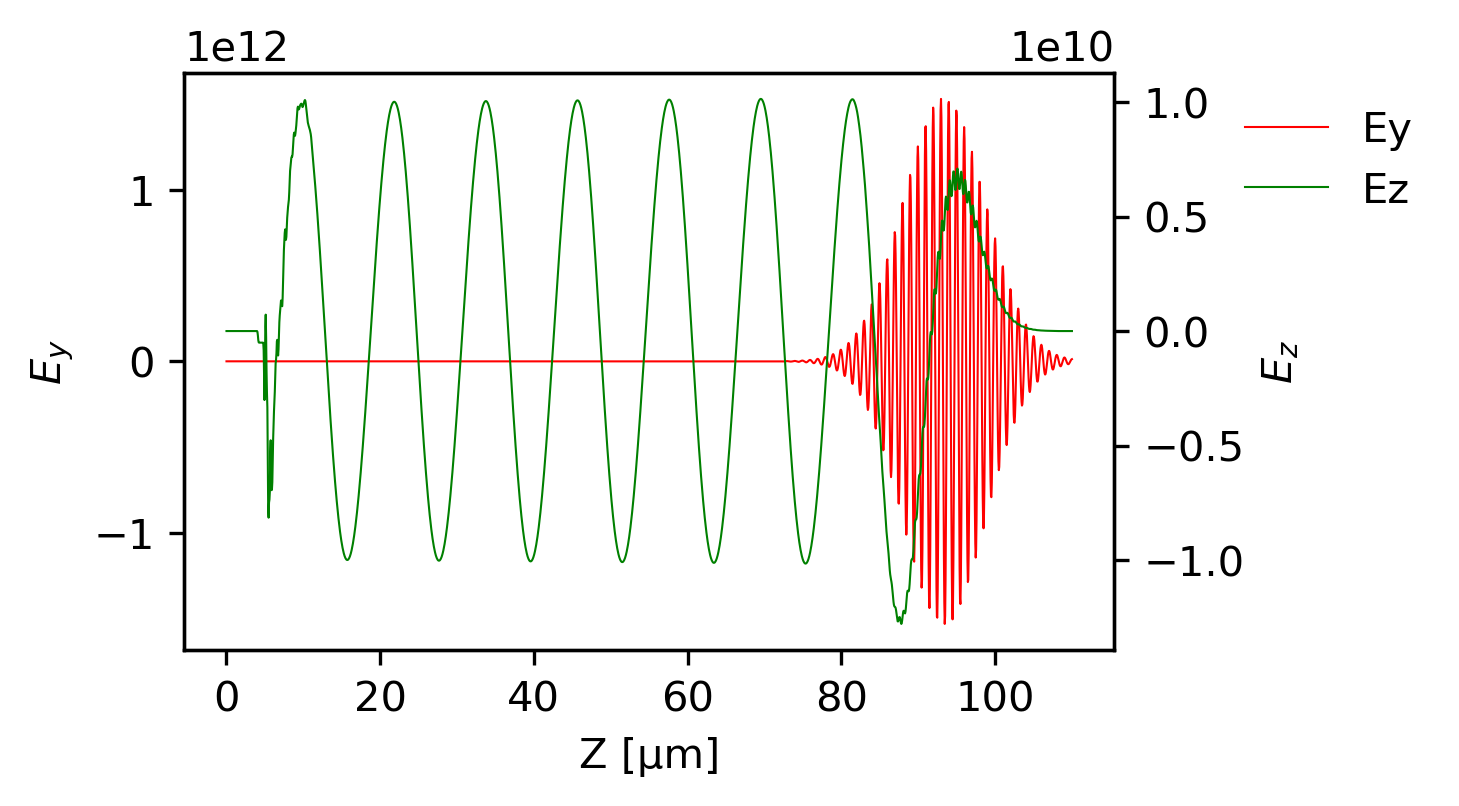

In [9]:
fig_width = 4
fig_height = 2.5
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)

l1, = ax.plot(axis_z*1e6, Ey, color="red", linewidth=0.5, label="Ey")
ax.set_ylabel(r"$E_y$")
ax2 = ax.twinx()
l2, = ax2.plot(axis_z*1e6, Ez, color="green", linewidth=0.5, label="Ez")
ax2.set_ylabel(r"$E_z$")
ax.set_xlabel("Z [μm]")

# Combine legends and place outside
ax.legend(
    handles=[l1, l2],
    loc="upper left",
    bbox_to_anchor=(1.1, 1.),
    frameon=False
)

#plt.tight_layout()
plt.show()


## Plot the electron density and wave field Ez what do you notice?

Text(0, 0.5, '$E_z / E_{zmax}$')

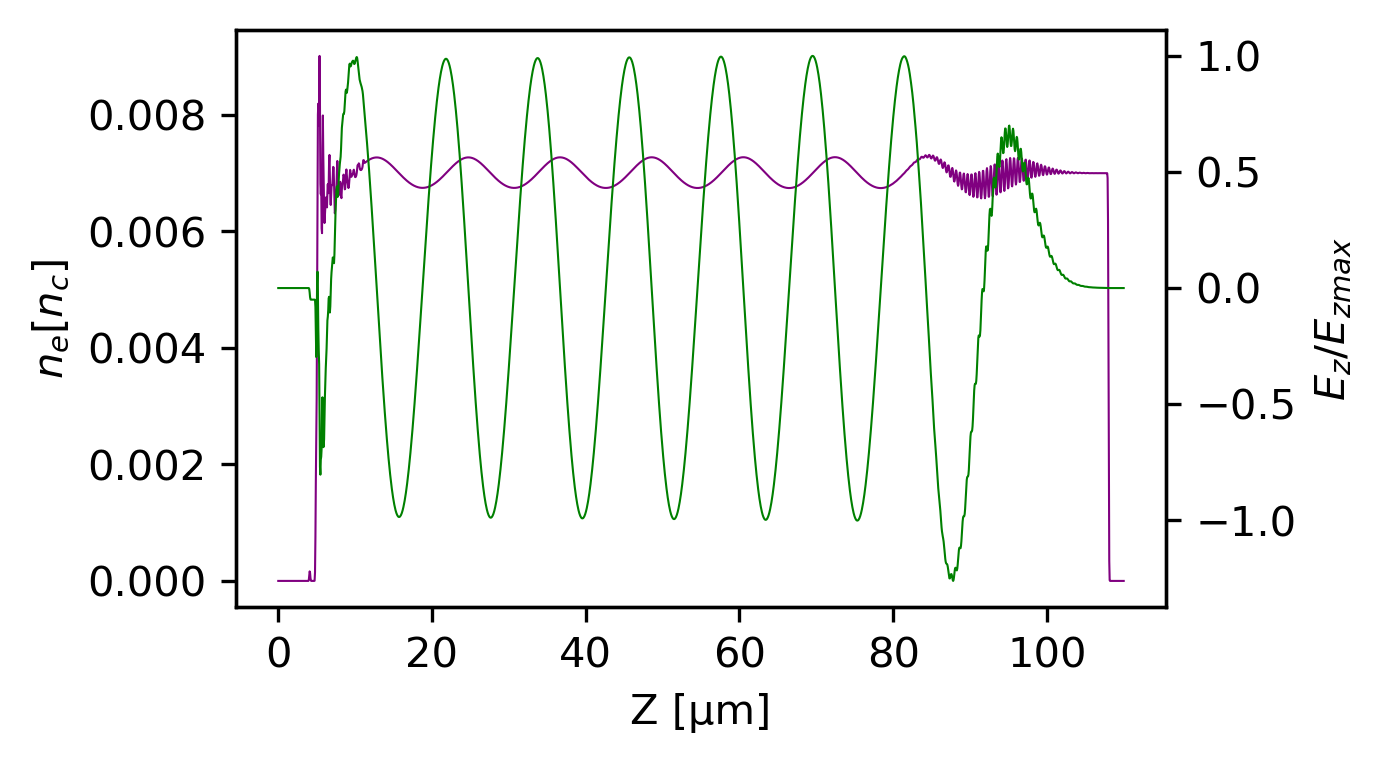

In [10]:
fig_width = 4
fig_height = 2.5
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)

ax.plot(axis_z*1e6, norm_ne, color="purple", linewidth=0.5)
ax.set_ylabel(r"$n_e [n_c]$")
ax.set_xlabel("Z [μm]")
ax2 = ax.twinx()
ax2.plot(axis_z*1e6, Ez/np.max(Ez), color="green", linewidth=0.5, label="Ez")
ax2.set_ylabel(r"$E_z / E_{zmax}$")

### We want to look at the dispersion relation for electromagneticwaves in plasma without magnetic field.The plasma frequency plays the role of cutoﬀ frequency. Waves with frequencies lower than $\omega_p$ cannot propagate in plasma.


# $$\omega^2 = k^2 c^2 + \omega_p^2$$


### We need to take our data into the frequency space, this means taking an FFT. Lets creat a matrix where we store the fields for every iteration.

In [11]:
iters = data.iterations
N = len(iters)
N
Ex0, _ = data.get_field(iteration=iters[0], field='E', coord='z')
Nx = len(Ex0)

# Full time × space matrix
Ez_mat = np.zeros((N, Nx))
Ey_mat = np.zeros((N, Nx))
for i, it in enumerate(iters):
    Ez, _ = data.get_field(iteration=it, field='E', coord='z')
    Ey, _ = data.get_field(iteration=it, field='E', coord='y')
    Ez_mat[i] = Ez
    Ey_mat[i] = Ey

# optional, you can save these field to a path 
#save_path = ""
#np.save(save_path + "/Ez_stack.npy", Ez_stack)
#np.save(save_path + "/Ey_stack.npy", Ey_stack)

In [16]:
np.shape(Ey_mat)

(1051, 2048)

In [ ]:
# optional, you can save these field to a path 
#Ey_mat = np.load(save_path + "/Ey_stack.npy")
#Ez_mat = np.load(save_path + "/Ez_stack.npy")

### We take the fft in space (x) to go to k space and the fft in time (t) to go to $\omega$ space. Note we are going to normalize these values to the wave number and the plasma frequency respectively. 

In [12]:
Ey0, info_Ey0 = data.get_field(iteration=iters[0], field='E', coord='z')
# Normalize to plasma wavenumber and plasma frequency 
# plasma frequency
w_p = np.sqrt((ne*qe**2)/ (epsilon0*me))
# plasma wavelength 
k_p =  w_p / clight
#################################################################
# delta omega axis 
time_axis = data.t               # length Nt
dt = np.diff(time_axis)[0]
Nt = len(time_axis)
freq_omega = np.fft.fftfreq(Nt, d=dt) * 2*np.pi   # convert cycles/s → rad/s
Omega = freq_omega[:Nt//2]    # keep positive ω
# delta k axis 
z_axis = info_Ey0.z
dz = np.diff(z_axis)[0]
Nz = len(z_axis)
freq_k = np.fft.fftfreq(Nz, d=dz) * 2*np.pi       # rad/m
K = scipy.fft.fftshift(freq_k)
Omega_norm = Omega / w_p      # dimensionless frequency
K_norm = -K / k_p              # dimensionless wavenumber

In [17]:
omega_l = np.sqrt(w_p**2 + clight**2*K**2)
vg = clight*np.sqrt(1 - w_p**2 / omega_l**2)
k_trim = np.linspace(-20,20,1000)
omega_light = np.ones(len(k_trim)) * np.abs(k_trim)   # if you want both + and - branches, use abs


## take the fft of the laser matrix and wakefield matrix 

In [14]:
Ey_fft = scipy.fft.fft2(Ey_mat)                 # full ω,k plane
Ey_fft = np.abs(Ey_fft)

Ey_fft_shift = scipy.fft.fftshift(Ey_fft, axes=(1,))  # shift only k-axis
Ey_fft_wk = Ey_fft_shift[:Nt//2, :]             # keep positive ω

Ey_fft_wk_norm = Ey_fft_wk / np.max(Ey_fft_wk)

Ez_fft = scipy.fft.fft2(Ez_mat)                 # full ω,k plane
Ez_fft = np.abs(Ez_fft)

Ez_fft_shift = scipy.fft.fftshift(Ez_fft, axes=(1,))  # shift only k-axis
Ez_fft_wk = Ez_fft_shift[:Nt//2, :]             # keep positive ω

Ez_fft_wk_norm = Ez_fft_wk / np.max(Ez_fft_wk)

# What do you see from the dispersion plot ? 

(0.0, 5.0)

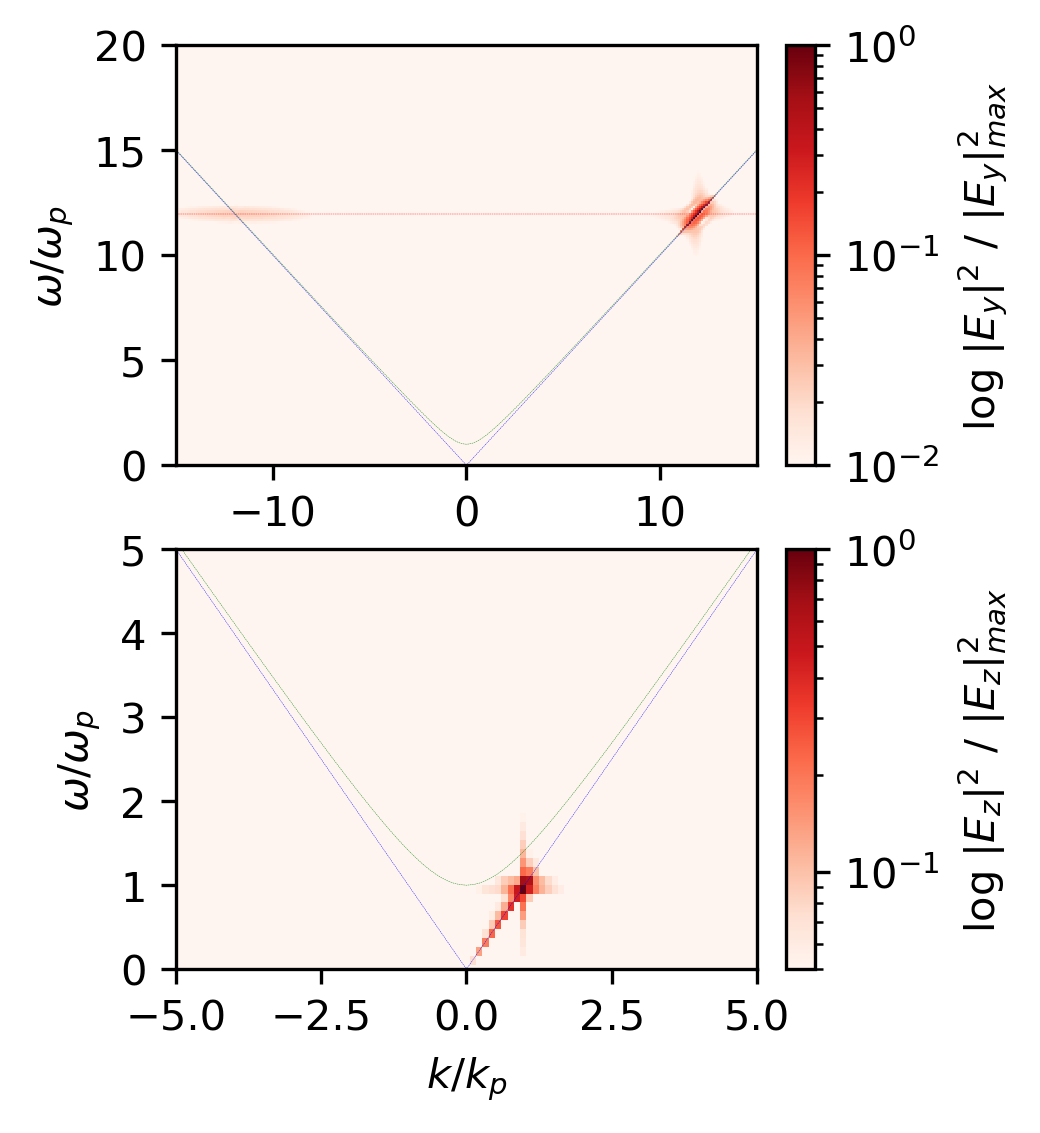

In [18]:
fig_width = 2.5 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, (ax,ax2) = plt.subplots(2,1,figsize=(fig_width, 2*fig_height), dpi=300)

Ey_wk_map = ax.pcolormesh(K_norm, Omega_norm, Ey_fft_wk_norm,norm = colors.LogNorm(vmin =1e-2, vmax =1), shading='auto',cmap="Reds")
ax.plot(K_norm,omega_l/w_p, linewidth = 0.1, color = "green",linestyle = "--")
ax.axhline(y= w_l/w_p, linewidth = 0.1, color = "red",linestyle = "--")
ax.plot(k_trim,omega_light, linewidth = 0.1, color = "blue",linestyle = "--")
cb1 = add_colorbar(Ey_wk_map)
cb1.set_label('log $|E_y|^2$ / $|E_y|^2_{max}$')
ax.tick_params('x')
ax.tick_params('y')
ax.set_ylabel(r'$\omega / \omega_p$')
ax.set_xlabel(r'$k / k_p$')
ax.set_xlim(-15,15)
ax.set_ylim(0,20)



Ez_wk_map = ax2.pcolormesh(K_norm, Omega_norm, Ez_fft_wk_norm,norm = colors.LogNorm(vmin =5e-2, vmax =1), shading='auto',cmap="Reds")
ax2.plot(K_norm,omega_l/w_p, linewidth = 0.1, color = "green",linestyle = "--")
ax2.plot(k_trim,omega_light, linewidth = 0.1, color = "blue",linestyle = "--")

cb1 = add_colorbar(Ez_wk_map)
ax2.set_ylabel(r'$\omega / \omega_p$')
cb1.set_label('log $|E_z|^2$ / $|E_z|^2_{max}$')
ax2.tick_params('x')
ax2.tick_params('y')
#ax2.set_yticklabels([])
ax2.set_xlabel(r'$k / k_p$')
ax2.set_xlim(-5,5)
ax2.set_ylim(0,5)